# VAE outlier detection on KDD Cup '99 dataset

## Method

The Variational Auto-Encoder ([VAE](https://arxiv.org/abs/1312.6114)) outlier detector is first trained on a batch of unlabeled, but normal (*inlier*) data. Unsupervised training is desireable since labeled data is often scarce. The VAE detector tries to reconstruct the input it receives. If the input data cannot be reconstructed well, the reconstruction error is high and the data can be flagged as an outlier. The reconstruction error is either measured as the mean squared error (MSE) between the input and the reconstructed instance or as the probability that both the input and the reconstructed instance are generated by the same process.

## Dataset

The outlier detector needs to detect computer network intrusions using TCP dump data for a local-area network (LAN) simulating a typical U.S. Air Force LAN. A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection is labeled as either normal, or as an attack.

There are 4 types of attacks in the dataset:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R: unauthorized access to local superuser (root) privileges;
- probing: surveillance and other probing, e.g., port scanning.

The dataset contains about 5 million connection records.

There are 3 types of features:

- basic features of individual connections, e.g. duration of connection
- content features within a connection, e.g. number of failed log in attempts
- traffic features within a 2 second window, e.g. number of connections to the same host as the current connection

In [1]:
import logging
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, InputLayer

from alibi_detect.datasets import fetch_kdd
from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_tabular

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load dataset

We only keep a number of continuous (18 out of 41) features.

In [2]:
kddcup = fetch_kdd(percent10=True)  # only load 10% of the dataset
print(kddcup.data.shape, kddcup.target.shape)

(494021, 18) (494021,)


Assume that a model is trained on *normal* instances of the dataset (not outliers) and standardization is applied:

In [3]:
np.random.seed(0)
normal_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=400000, perc_outlier=0)
X_train, y_train = normal_batch.data.astype('float'), normal_batch.target
print(X_train.shape, y_train.shape)
print('{}% outliers'.format(100 * y_train.mean()))

(400000, 18) (400000,)
0.0% outliers


In [4]:
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)

Apply standardization:

In [5]:
X_train = (X_train - mean) / stdev

## Load or define outlier detector

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can either manually download the relevant files in the [od_vae_kddcup](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/od_vae_kddcup/) folder to e.g. the local directory ```my_dir```. Alternatively,  if you have [Google Cloud SDK](https://cloud.google.com/sdk/docs/) installed, you can download the whole folder as follows:

```bash
!gsutil cp -r gs://seldon-models/alibi-detect/od_vae_kddcup my_dir
```

In [6]:
load_outlier_detector = True

In [7]:
filepath = './od_vae_kddcup/'  # change to directory where model is downloaded
if load_outlier_detector:  # load pretrained outlier detector
    od = load_detector(filepath)
else:  # define model, initialize, train and save outlier detector
    n_features = X_train.shape[1]
    latent_dim = 2
    
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(n_features,)),
          Dense(20, activation=tf.nn.relu),
          Dense(15, activation=tf.nn.relu),
          Dense(7, activation=tf.nn.relu)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(7, activation=tf.nn.relu),
          Dense(15, activation=tf.nn.relu),
          Dense(20, activation=tf.nn.relu),
          Dense(n_features, activation=None)
      ])
    
    # initialize outlier detector
    od = OutlierVAE(threshold=None,  # threshold for outlier score
                    score_type='mse',  # use MSE of reconstruction error for outlier detection
                    encoder_net=encoder_net,  # can also pass VAE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    latent_dim=latent_dim,
                    samples=5)
    # train
    od.fit(X_train,
           loss_fn=elbo,
           cov_elbo=dict(sim=.1),
           epochs=5,
           verbose=True)
    
    # save the trained outlier detector
    save_detector(od, filepath)

If `load_outlier_detector` equals False, the warning tells us we still need to set the outlier threshold. This can be done with the `infer_threshold` method. We need to pass a batch of instances and specify what percentage of those we consider to be normal via `threshold_perc`. Let's assume we have some data which we know contains around 5% outliers. The percentage of outliers can be set with `perc_outlier` in the `create_outlier_batch` function.

In [8]:
np.random.seed(0)
perc_outlier = 5
threshold_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=perc_outlier)
X_threshold, y_threshold = threshold_batch.data.astype('float'), threshold_batch.target
X_threshold = (X_threshold - mean) / stdev
print('{}% outliers'.format(100 * y_threshold.mean()))

5.0% outliers


In [9]:
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))

New threshold: 2.2026272058486898


We could have also inferred the threshold from the normal training data by setting `threshold_perc` e.g. at 99 and adding a bit of margin on top of the inferred threshold. Let's save the outlier detector with updated threshold:

In [10]:
save_detector(od, filepath)

## Detect outliers

We now generate a batch of data with 10% outliers and detect the outliers in the batch. 

In [11]:
np.random.seed(1)
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float'), outlier_batch.target
X_outlier = (X_outlier - mean) / stdev
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 18) (1000,)
10.0% outliers


Predict outliers:

In [12]:
od_preds = od.predict(X_outlier,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
print(list(od_preds['data'].keys()))

['is_outlier', 'feature_score', 'instance_score']


## Display results

F1 score and confusion matrix:

F1 score: 0.9753694581280788


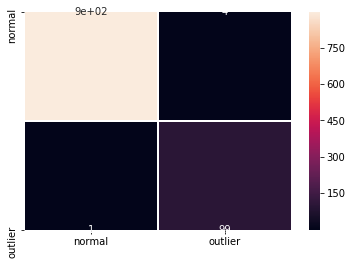

In [13]:
labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot instance level outlier scores vs. the outlier threshold:

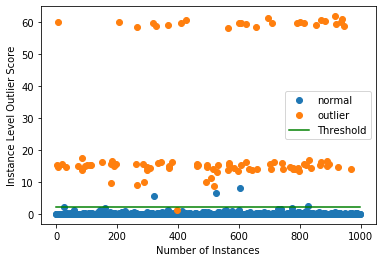

In [14]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)

We can clearly see that some outliers are very easy to detect while others have outlier scores closer to the normal data.

## Investigate instance level outlier

We can now take a closer look at some of the individual predictions on `X_outlier`. 

In [15]:
X_recon = od.vae(X_outlier).numpy()  # reconstructed instances by the VAE

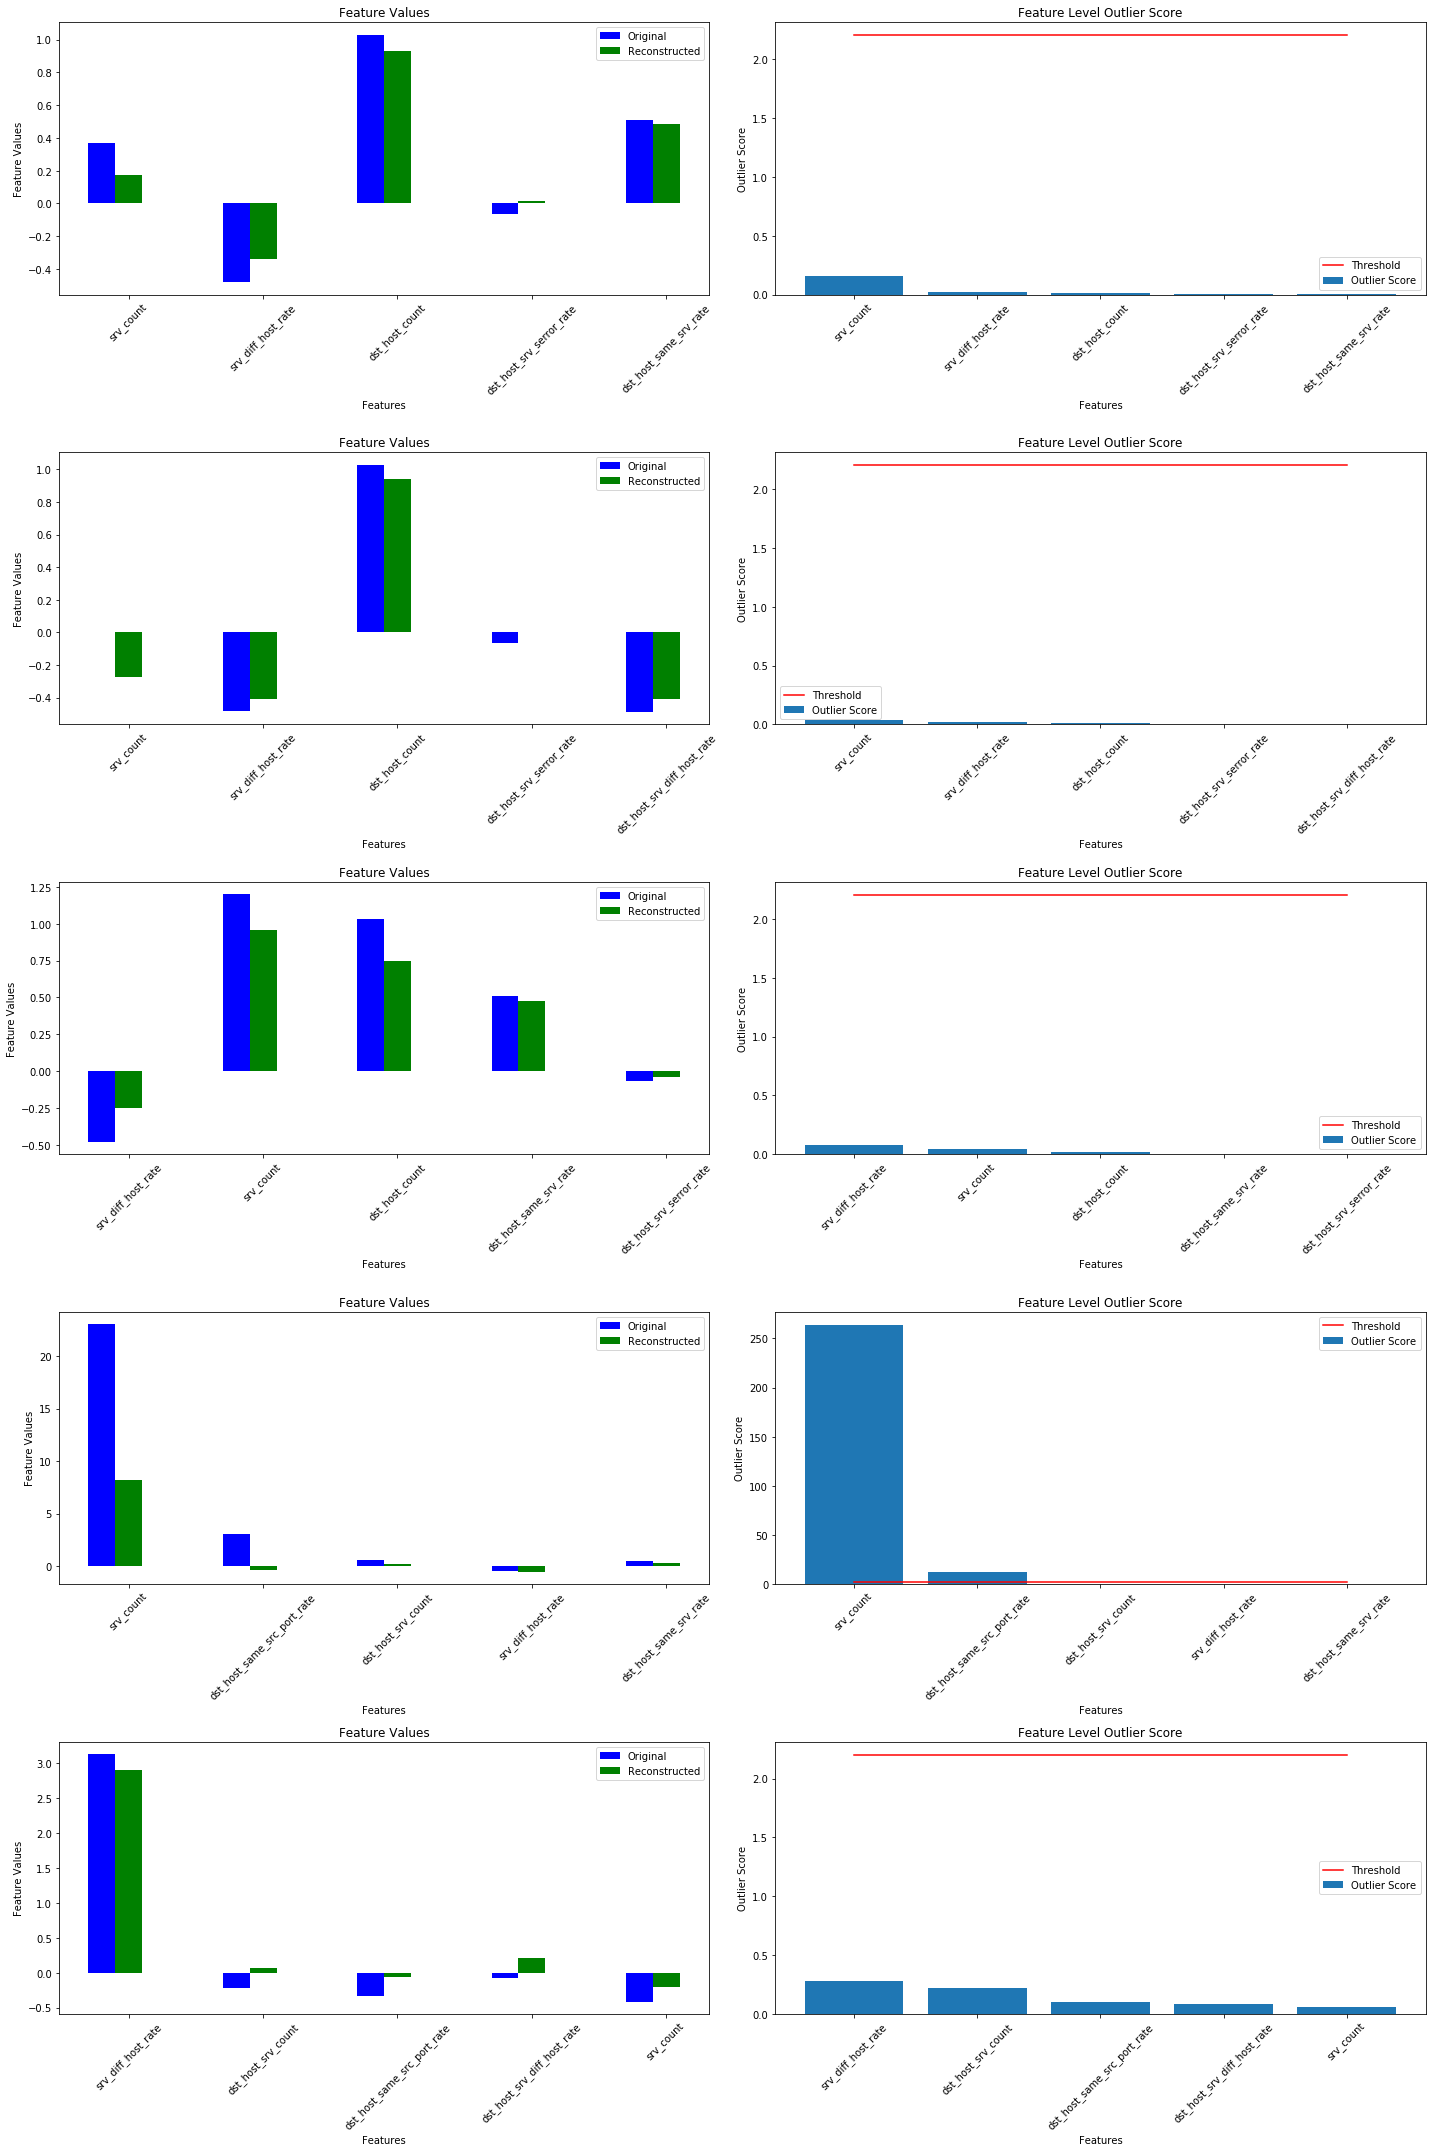

In [16]:
plot_feature_outlier_tabular(od_preds,
                             X_outlier,
                             X_recon=X_recon,
                             threshold=od.threshold,
                             instance_ids=None,  # pass a list with indices of instances to display
                             max_instances=5,  # max nb of instances to display
                             top_n=5,  # only show top_n features ordered by outlier score
                             outliers_only=False,  # only show outlier predictions
                             feature_names=kddcup.feature_names,  # add feature names
                             figsize=(20, 30))

The `srv_count` feature is responsible for a lot of the displayed outliers.